# Combined framework with Sensitivity

### 0. Introduction

This file shows how MHE and NMPC are coupled together

In [1]:
from nmpc_mhe.aux.utils import load_iguess
from nmpc_mhe.pyomo_dae.MHEGen_pyDAE import MheGen_DAE
from sample_mods.cstr_rodrigo.cstr_c_nmpc import cstr_rodrigo_dae
from pyomo.environ import *
import os, sys
import matplotlib.pyplot as plt

### 1. Object set-up

In [2]:
states = ["Ca", "T", "Tj"]
measurements = ['T']
controls = ["u1"]
u_bounds = {"u1": (200, 1000)}
state_bounds = {"Ca": (0.0, None), "T": (2.0E+02, None), "Tj": (2.0E+02, None)}
ref_state = {("Ca", (0,)): 0.010}
mod = cstr_rodrigo_dae(2, 2)  #: Some model

In [3]:
#: MHE-NMPC class
e = MheGen_DAE(mod, 2, states, controls, states, measurements,
               u_bounds=u_bounds,
               ref_state=ref_state,
               override_solver_check=True,
               var_bounds=state_bounds,
               k_aug_executable='/home/dav0/in_dev_/WorkshopFraunHofer/caprese/k_aug/bin/k_aug',
               dot_driver_executable='/home/dav0/in_dev_/WorkshopFraunHofer/caprese/k_aug/dot_sens')

New model at 140716837289168
New timebounds defined!
New model at 140717445612480
New timebounds defined!
Model: unknown Bounds activated
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
New model at 140716837013296
New model at 140716837076576
New timebounds defined!
New timebounds defined!
Model: LSMHE (Least-Squares MHE) Bounds activated


W0[[Initializing MHE]]The Q_MHE and R_MHE matrices are diagonal.


In [4]:
#: Covariance Matrices
Q = {}
U = {}
R = {}
Q['Ca'] = 1.11
Q['T'] = 99.0
Q['Tj'] = 1.1
U['u1'] = 0.22
R['T'] = 1.22
e.set_covariance_disturb(Q)
e.set_covariance_u(U)
e.set_covariance_meas(R)
e.create_rh_sfx()
e.get_state_vars()

{'Ca': [(0,)], 'T': [(0,)], 'Tj': [(0,)]}
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_steady_ref]]labels at 1568359937.--------------------


### 2. Problem loop

In [5]:
#: Initial guesses
e.load_iguess_steady()
load_iguess(e.SteadyRef, e.PlantSample, 0, 0)
e.solve_dyn(e.PlantSample)

-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]SteadyRef.--------------------
/tmp/tmptpn3x_g2.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                              bound_push = 1e-07                 yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobia

optimal


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       

optimal


0

In [6]:
#: Prepare MHE
e.init_lsmhe_prep(e.PlantSample)
e.shift_mhe()
e.init_step_mhe()
e.solve_dyn(e.lsmhe,
            skip_update=False,
            max_cpu_time=600,
            ma57_pre_alloc=5, tag="lsmhe")  #: Pre-loaded mhe solve

e.prior_phase()
e.deact_icc_mhe()  #: Remove the initial conditions

-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[init_lsmhe_prep]]Preparation phase MHE.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]Measurement to:0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmprl_jvri4.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 y

optimal


                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:  

optimal


                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:  

optimal


/tmp/tmp5gq9cbxw.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables.................

optimal


                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:  

optimal


/tmp/tmp_qnlj9bw.pyomo.nl -AMPL halt_on_ampl_error=yes 
Ipopt vanilla0: halt_on_ampl_error=yes
halt_on_ampl_error=yes


List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 1e-06                 yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 5                     yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 3000                  yes
                             mu_strategy = adaptive              yes
                             output_file = prep_mhe.txt          yes
                       print_info_string = yes                   yes
                      pri

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmp0s3smri4.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = ye

optimal


                                max_iter = 3000                  yes
                             output_file = lsmhe_log.log         yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      513
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       67

Total number of variables............................:      146
                     variables with only lower bounds:       48
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      129
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality con

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.4993; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 129
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 17
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601034229527142 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033361066351 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 129, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 513
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 67
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000000
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 94
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


In [7]:
#: Prepare NMPC
e.find_target_ss()
e.create_nmpc()
e.create_suffixes_nmpc()
e.update_targets_nmpc()
e.compute_QR_nmpc(n=-1)
e.new_weights_olnmpc(1e-04, 1e+06)

-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[find_target_ss]]Attempting to find steady state.--------------------
New model at 140716837287888
New timebounds defined!
Model: SteadyRef2 (reference) Bounds activated
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]SteadyRef2 (reference).--------------------
/tmp/tmpjz0gjesc.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 10000                 yes
              

W0[[find_target_ss]]No reference state was given, using default.


Total number of equality constraints.................:        5
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  9.1937940e-03 1.82e-12 2.38e-02  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0 y
   1  9.1786567e-03 4.65e-04 1.98e-02  -1.0 1.27e+00    -  9.90e-01 1.00e+00f  1 
   2  7.4981691e-03 6.50e+00 1.09e-02  -1.0 1.49e+02    -  1.00e+00 1.00e+00h  1 Nhj 
   3  1.4333990e-04 6.27e+02 3.09e+00  -1.0 2.77e+03    -  1.00e+00 5.00e-01h  2 
   4  1.3966651e-06 4.14e+02 8.51e-01  -1.0 2.36e+03    -  1.00e+00 1.00e+00h  1 
   5  1.5577639e-04 3.45e+02 1.81e+00  -1.0 3.01e+03    -  1.00e+00 5.00e-01h  2 
   6  4.8728216e-04 2.16e+02 3.38e-01  -1.0 2.15e+03    -  1.00e+00 1.00e+00h  1 
   7  4.4520522e-04

optimal
W0[[Initializing NMPC]]With 5 fe and 3 cp.


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[find_target_ss]]Target: solve done.--------------------
('Ca', (0,))
target Ca 	key (0,) 	weight 108.769024 	value 0.010000
target u1 	value 364.870073
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
New model at 140716836578480
New timebounds defined!


In [8]:
ca = e.PlantSample.Ca[2, 0]
t = e.PlantSample.T[2, 0]
u = e.PlantSample.u1[2]
tj = e.PlantSample.Tj[2, 0]

ca_mhe = e.lsmhe.Ca[10, 0]
t_mhe = e.lsmhe.T[10, 0]
tj_mhe = e.lsmhe.Tj[10, 0]

spl = []
ul = []
cal = []
tl = []
tjl = []

ca_mhel = []
t_mhel = []
tj_mhel = []

In [9]:
#: Problem loop
for i in range(0, 100):  #: Five steps
    #: set-point change
    if i in [30 * (j * 2) for j in range(0, 100)]:
        ref_state = {("Ca", (0,)): 0.018}
        e.change_setpoint(ref_state=ref_state, keepsolve=True, wantparams=True, tag="sp")
        e.compute_QR_nmpc(n=-1)
        e.new_weights_olnmpc(1e-04, 1e+06)
    #: set point change
    elif i in [30 * (j * 2 + 1) for j in range(0, 100)]:
        ref_state = {("Ca", (0,)): 0.021}
        e.change_setpoint(ref_state=ref_state, keepsolve=True, wantparams=True, tag="sp")
        e.compute_QR_nmpc(n=-1)
        e.new_weights_olnmpc(1e-04, 1e+06)

    #: Plant
    e.solve_dyn(e.PlantSample, stop_if_nopt=True)
    cal.append(value(ca))
    tl.append(value(t))
    tjl.append(value(tj))
    ul.append(value(u))
    e.update_state_real()  # Update the current state
    e.update_soi_sp_nmpc()  #: To keep track of the state of interest.

    e.update_measurement()  # Update the current measurement
    e.compute_y_offset()  #: Get the offset for y
    #: State-estimation MHE
    e.preparation_phase_mhe(as_strategy=False)
    stat = e.solve_dyn(e.lsmhe,
                       skip_update=False, iter_max=500,
                       jacobian_regularization_value=1e-04,
                       max_cpu_time=600, tag="lsmhe", keepsolve=False, wantparams=False)

    if stat != 0:
        sys.exit()
    #: Prior-phase and arrival cost
    ca_mhel.append(value(ca_mhe))
    t_mhel.append(value(t_mhe))
    tj_mhel.append(value(tj_mhe))
    e.update_state_mhe()  #: get the state from mhe
    e.prior_phase()

    e.print_r_mhe()
    e.print_r_dyn()
    #: Control NMPC
    e.preparation_phase_nmpc(as_strategy=False, make_prediction=False)
    stat_nmpc = e.solve_dyn(e.olnmpc, skip_update=False, max_cpu_time=300, tag="olnmpc")
    if stat_nmpc != 0:
        sys.exit()
    e.print_r_nmpc()
    e.update_u(e.olnmpc)
    #: Plant cycle
    e.cycleSamPlant(plant_step=True)
    e.plant_uinject(e.PlantSample, src_kind="dict", skip_homotopy=True)
    e.noisy_plant_manager(sigma=0.0015, action="apply", update_level=True)

#: print our state of interest

-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]SteadyRef2 (reference).--------------------
Solver log file: '/tmp/tmpue4qj2e6_ipopt.log'
Solver solution file: '/tmp/tmpsucgx5gh.pyomo.sol'
Solver problem files: ('/tmp/tmpsucgx5gh.pyomo.nl',)
/tmp/tmpsucgx5gh.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 500                   yes
                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                     

optimal


/tmp/tmpj4lwu6y4.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables.................

optimal


List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonze

optimal


                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      510
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       73

Total number of variables............................:      146
                     variables with only lower bounds:       48
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      126
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_p

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.499927; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033727254064 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.6010333029118 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000000
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19 

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpcdcboptj.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time =

optimal


/tmp/tmpuby9qzjn.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables.................

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I1[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I1[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.38375186432730146		Current value \% \% 	 0.01806907517298384
10.568507446030083
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I1[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I1[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmptfx2p44n.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automati

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I1[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I1[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I1[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpf3zi916_.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.330441; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033728478665 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033305452606 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000229
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I1[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I1[[print_r_mhe]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I1[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I1[[print_r_dyn]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I1[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==

optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I1[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I1[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I1[[Solving with IPOPT	]]Dummy I 2.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I1[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I1[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I1[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I1[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I1[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I1[[Solving with IPOPT	]]Dummy I 4.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I1[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I1[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I1[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I1[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------


optimal


/tmp/tmp_yedhh97.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessi

optimal


/tmp/tmp7av4cd5l.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables.................

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I2[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I2[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.12361980851484901		Current value \% \% 	 0.01797774827269406
-1.2789769243681803e-11
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I2[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I2[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpsr4he_b1.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_aut

optimal


/tmp/tmphs3_dk4l.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500                   yes
                             output_file = lsmhe_log.log         yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      510
Number of nonzeros in inequality 

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.610638; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033724008362 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033296029392 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.001397
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I2[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I2[[print_r_mhe]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I2[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I2[[print_r_dyn]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I2[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==

optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I2[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I2[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I2[[Solving with IPOPT	]]Dummy I 2.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I2[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I2[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I2[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I2[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I2[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I2[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I2[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I2[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I2[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I2[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpu38qfa7a.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time =

optimal


/tmp/tmpk1ghxu7k.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables.................

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I3[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I3[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.05152744679714163		Current value \% \% 	 0.018009274778366526
-5.115907697472721e-13
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I3[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I3[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmp9m5mww_u.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_aut

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I3[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I3[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I3[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpx6v7ojfv.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.228895; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033734393733 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033315382415 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000266
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I3[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I3[[print_r_mhe]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I3[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I3[[print_r_dyn]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I3[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I3[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I3[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I3[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I3[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I3[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I3[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I3[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I3[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I3[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I3[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I3[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I3[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I3[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpai6vfh04.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time =

optimal


/tmp/tmpo3jrwcy4.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables.................

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I4[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I4[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.00010779152675234469		Current value \% \% 	 0.01799998043555186
-5.684341886080802e-14
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I4[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I4[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmp4h8asy6o.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_a

optimal


/tmp/tmp6euj6n94.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500                   yes
                             output_file = lsmhe_log.log         yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      510
Number of nonzeros in inequality 

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.722495; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033709415356 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.60103327132576 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000029
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I4[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I4[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I4[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I4[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I4[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I4[[Solving with IPOPT	]]Dummy I 2.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I4[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I4[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I4[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I4[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I4[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I4[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I4[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I4[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I4[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I4[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmprz8p2eww.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time =

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I4[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I4[[print_r_nmpc]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I4[[print_r_nmpc]]Results suffix 1568359937.--------------------
Current values	 0.018 ('Ca', (0,))
------------------------------------------------------------------------------------------------------------------------
I[[cycleSamPlant]] Cycling initial state. Iteration timing(s):	0.493851900100708
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I5[[plant_input]]Continuation_plant, src_kind=dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I5[[plant_input]]Target 260.568507, Current 260.568507, n_steps 5.--------------------
Current Gap /\% 0.000000
-==--==--==--==--==--==--==--==--==--==--==--==--=

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I5[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I5[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.22319999308647678		Current value \% \% 	 0.018040175836420543
0.0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I5[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I5[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpixiq_gm0.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I5[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I5[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I5[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmplji4b10e.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.524; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033737092063 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033324615628 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.003077
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I5[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I5[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I5[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I5[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I5[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I5[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I5[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I5[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I5[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I5[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I5[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I5[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I5[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I5[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I5[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I5[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpug2yx1_b.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time =

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I5[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I5[[print_r_nmpc]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I5[[print_r_nmpc]]Results suffix 1568359937.--------------------
Current values	 0.018 ('Ca', (0,))
------------------------------------------------------------------------------------------------------------------------
I[[cycleSamPlant]] Cycling initial state. Iteration timing(s):	0.468181848526001
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I6[[plant_input]]Continuation_plant, src_kind=dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I6[[plant_input]]Target 260.568507, Current 260.568507, n_steps 5.--------------------
Current Gap /\% 0.000000
-==--==--==--==--==--==--==--==--==--==--==--==--=

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I6[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I6[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.022722541485697304		Current value \% \% 	 0.01799590978059588
0.0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I6[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I6[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmplpu2uoxg.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I6[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I6[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I6[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp_ko6ymm2.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I6[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I6[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.225664; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033754030517 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033337547943 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000103
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I6[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I6[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I6[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I6[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I6[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I6[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I6[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I6[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I6[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I6[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I6[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I6[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I6[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I6[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I6[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I6[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpxf5r52cg.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time =

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I6[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I6[[print_r_nmpc]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I6[[print_r_nmpc]]Results suffix 1568359937.--------------------
Current values	 0.018 ('Ca', (0,))
------------------------------------------------------------------------------------------------------------------------
I[[cycleSamPlant]] Cycling initial state. Iteration timing(s):	0.46316003799438477
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I7[[plant_input]]Continuation_plant, src_kind=dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I7[[plant_input]]Target 260.568507, Current 260.568507, n_steps 5.--------------------
Current Gap /\% 0.000000
-==--==--==--==--==--==--==--==--==--==--==--==-

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I7[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I7[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.14564895412732876		Current value \% \% 	 0.018026216649533508
0.0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I7[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I7[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpqu_k5v6p.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I7[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I7[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I7[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpsbekd7z5.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I7[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I7[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.614329; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033751545295 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.60103333308333 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.001345
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I7[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I7[[print_r_mhe]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I7[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I7[[print_r_dyn]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I7[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==

optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I7[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I7[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I7[[Solving with IPOPT	]]Dummy I 2.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I7[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I7[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I7[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I7[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I7[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I7[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I7[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I7[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I7[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I7[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpuzuvd14s.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time =

optimal


                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
To

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I8[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I8[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.06623456506788471		Current value \% \% 	 0.017988077616421565
0.0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I8[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I8[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmp0je0jnyw.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I8[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I8[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I8[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpcebzp2nt.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.310304; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033753796566 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.60103333696301 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000374
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I8[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I8[[print_r_mhe]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I8[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I8[[print_r_dyn]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I8[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==

optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I8[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I8[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I8[[Solving with IPOPT	]]Dummy I 2.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I8[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I8[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I8[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I8[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I8[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I8[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I8[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I8[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I8[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I8[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpnkjcc_5f.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time =

optimal


/tmp/tmpkx6e9wmv.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables.................

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I9[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I9[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.203816848392066		Current value \% \% 	 0.01796331280564606
0.0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I9[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I9[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpp2327vpw.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I9[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I9[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I9[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp2j4bp12x.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.630514; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033749149098 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033330094594 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.002412
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I9[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I9[[print_r_mhe]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I9[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I9[[print_r_dyn]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I9[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==

optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I9[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I9[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I9[[Solving with IPOPT	]]Dummy I 2.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I9[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I9[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I9[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I9[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I9[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I9[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I9[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I9[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I9[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I9[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp6lv5sy23.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time =

optimal


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I10[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I10[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.1241802169036721		Current value \% \% 	 0.018022352276868023
0.0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I10[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I10[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpko8s2hgt.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling =

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I10[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I10[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I10[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmplfsl3fg3.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.303152; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033753128409 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033336178988 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.001215
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I10[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I10[[print_r_mhe]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I10[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I10[[print_r_dyn]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I10[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--=

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I10[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I10[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I10[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I10[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I10[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I10[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I10[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I10[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I10[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I10[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I10[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I10[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I10[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpyanwk53d.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I10[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I10[[print_r_nmpc]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I10[[print_r_nmpc]]Results suffix 1568359937.--------------------
Current values	 0.018 ('Ca', (0,))
------------------------------------------------------------------------------------------------------------------------
I[[cycleSamPlant]] Cycling initial state. Iteration timing(s):	0.4985990524291992
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I11[[plant_input]]Continuation_plant, src_kind=dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I11[[plant_input]]Target 260.568507, Current 260.568507, n_steps 5.--------------------
Current Gap /\% 0.000000
-==--==--==--==--==--==--==--==--==--==--==-

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I11[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I11[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.17437293591948358		Current value \% \% 	 0.01803138696620957
0.0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I11[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I11[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpf8ph4jyi.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling =

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I11[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I11[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I11[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp7vk51sk6.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.611589; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033750882628 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.60103333275786 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.001666
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I11[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I11[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I11[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I11[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I11[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I11[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I11[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I11[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I11[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I11[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I11[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I11[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I11[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I11[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I11[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I11[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp_1i434mk.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I11[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I11[[print_r_nmpc]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I11[[print_r_nmpc]]Results suffix 1568359937.--------------------
Current values	 0.018 ('Ca', (0,))
------------------------------------------------------------------------------------------------------------------------
I[[cycleSamPlant]] Cycling initial state. Iteration timing(s):	0.5025084018707275
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I12[[plant_input]]Continuation_plant, src_kind=dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I12[[plant_input]]Target 260.568507, Current 260.568507, n_steps 5.--------------------
Current Gap /\% 0.000000
-==--==--==--==--==--==--==--==--==--==--==-

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I12[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I12[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.05980842905488748		Current value \% \% 	 0.018010765355159507
0.0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I12[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I12[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpi_zuw694.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I12[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I12[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I12[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpoqhj0anv.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.524988; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.60103375184411 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033333949555 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000131
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I12[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I12[[print_r_mhe]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I12[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I12[[print_r_dyn]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I12[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--=

optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I12[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I12[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I12[[Solving with IPOPT	]]Dummy I 2.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I12[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I12[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I12[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I12[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I12[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I12[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I12[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I12[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I12[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I12[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp5pbeucm5.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
To

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I13[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I13[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.20001262369423184		Current value \% \% 	 0.018036002109967496
0.0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I13[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I13[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmparl_a_nk.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling 

optimal


/tmp/tmpzav1kx07.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500                   yes
                             output_file = lsmhe_log.log         yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      510
Number of nonzeros in inequality 

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.212059; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033755505291 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033338746674 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.002357
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I13[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I13[[print_r_mhe]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I13[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I13[[print_r_dyn]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I13[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--=

optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I13[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I13[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I13[[Solving with IPOPT	]]Dummy I 2.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I13[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I13[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I13[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I13[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I13[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I13[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I13[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I13[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I13[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I13[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpqug9_h0o.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       28
Total number of inequality constraints...............:        0
        ineq

optimal


/tmp/tmp1tzmj0x0.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equali

optimal


/tmp/tmpwke5iqm8.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500                   yes
                             output_file = lsmhe_log.log         yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      510
Number of nonzeros in inequality 

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.561506; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033752227831 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033334357902 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000004
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I14[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I14[[print_r_mhe]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I14[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I14[[print_r_dyn]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I14[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--=

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I14[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I14[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I14[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I14[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I14[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I14[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I14[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I14[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I14[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I14[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I14[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I14[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I14[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmprgsbf7mu.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


/tmp/tmp0d6vz__i.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables.................

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I15[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I15[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.02617842138888179		Current value \% \% 	 0.018004711953834098
0.0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I15[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I15[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmp9l9l9onc.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I15[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I15[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I15[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpfyblhm3m.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.637076; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033749967218 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033331540764 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000038
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I15[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I15[[print_r_mhe]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I15[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I15[[print_r_dyn]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I15[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--=

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I15[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I15[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I15[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I15[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I15[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I15[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I15[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I15[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I15[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I15[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I15[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I15[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I15[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp135xie_x.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I15[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I15[[print_r_nmpc]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I15[[print_r_nmpc]]Results suffix 1568359937.--------------------
Current values	 0.018 ('Ca', (0,))
------------------------------------------------------------------------------------------------------------------------
I[[cycleSamPlant]] Cycling initial state. Iteration timing(s):	0.5078616142272949
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I16[[plant_input]]Continuation_plant, src_kind=dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I16[[plant_input]]Target 260.568507, Current 260.568507, n_steps 5.--------------------
Current Gap /\% 0.000000
-==--==--==--==--==--==--==--==--==--==--==-

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I16[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I16[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.018122205124972514		Current value \% \% 	 0.018003261834919643
0.0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I16[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I16[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpv88c0c6_.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I16[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I16[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I16[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpkjph04kh.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.458427; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033752413992 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.60103333531715 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000016
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I16[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I16[[print_r_mhe]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I16[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I16[[print_r_dyn]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I16[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--=

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I16[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I16[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I16[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I16[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I16[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I16[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I16[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I16[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I16[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I16[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I16[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I16[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I16[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpvvvb5r5e.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


/tmp/tmp6lt3rp0q.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables.................

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I17[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I17[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.2578618711805852		Current value \% \% 	 0.01804641497442134
0.0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I17[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I17[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpzkvgff_y.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I17[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I17[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I17[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpgeu3zmee.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.642352; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.60103374996308 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033331503086 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.004063
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I17[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I17[[print_r_mhe]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I17[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I17[[print_r_dyn]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I17[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--=

optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I17[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I17[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I17[[Solving with IPOPT	]]Dummy I 2.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I17[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I17[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I17[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I17[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I17[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I17[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I17[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I17[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I17[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I17[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp4rq_ke35.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I17[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I17[[print_r_nmpc]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I17[[print_r_nmpc]]Results suffix 1568359937.--------------------
Current values	 0.018 ('Ca', (0,))
------------------------------------------------------------------------------------------------------------------------
I[[cycleSamPlant]] Cycling initial state. Iteration timing(s):	0.4922356605529785
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I18[[plant_input]]Continuation_plant, src_kind=dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I18[[plant_input]]Target 260.568507, Current 260.568507, n_steps 5.--------------------
Current Gap /\% 0.000000
-==--==--==--==--==--==--==--==--==--==--==-

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I18[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I18[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.02722895507239151		Current value \% \% 	 0.017995098626157575
0.0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I18[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I18[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpd15dtekn.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I18[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I18[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I18[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp60zzmtfg.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.468029; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033752150535 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033334891206 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000142
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I18[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I18[[print_r_mhe]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I18[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I18[[print_r_dyn]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I18[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--=

optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I18[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I18[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I18[[Solving with IPOPT	]]Dummy I 2.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I18[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I18[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I18[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I18[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I18[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I18[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I18[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I18[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I18[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I18[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpodchvrq2.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


/tmp/tmplq6dlsrg.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables.................

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I19[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I19[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.10260841315226639		Current value \% \% 	 0.01801846935222771
0.0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I19[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I19[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmp11_beh_x.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling =

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I19[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I19[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I19[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp3en31ay3.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.604755; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033751645259 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.60103333345549 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000680
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I19[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I19[[print_r_mhe]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I19[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I19[[print_r_dyn]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I19[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--=

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I19[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I19[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I19[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I19[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I19[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I19[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I19[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I19[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I19[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I19[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I19[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I19[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I19[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp0mle04yy.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I19[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I19[[print_r_nmpc]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I19[[print_r_nmpc]]Results suffix 1568359937.--------------------
Current values	 0.018 ('Ca', (0,))
------------------------------------------------------------------------------------------------------------------------
I[[cycleSamPlant]] Cycling initial state. Iteration timing(s):	0.5098485946655273
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I20[[plant_input]]Continuation_plant, src_kind=dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I20[[plant_input]]Target 260.568507, Current 260.568507, n_steps 5.--------------------
Current Gap /\% 0.000000
-==--==--==--==--==--==--==--==--==--==--==-

optimal


/tmp/tmpv0pbeq06.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equali

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I20[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I20[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I20[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpiwx4hass.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.32574; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033753729476 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033336915481 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000683
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I20[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I20[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I20[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I20[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I20[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I20[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I20[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I20[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I20[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I20[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I20[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I20[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I20[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I20[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I20[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I20[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpydbvls1c.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       28
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality con

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I21[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I21[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.26202553643642384		Current value \% \% 	 0.018047164434160646
0.0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I21[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I21[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmps4cyjgoh.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling 

optimal


/tmp/tmpnyib_ob0.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500                   yes
                             output_file = lsmhe_log.log         yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      510
Number of nonzeros in inequality 

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.63725; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.60103374890919 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.60103332998704 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.003958
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19 

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I21[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I21[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I21[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I21[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I21[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I21[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I21[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I21[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I21[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I21[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I21[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I21[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I21[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I21[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I21[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I21[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpd9615u5b.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I21[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I21[[print_r_nmpc]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I21[[print_r_nmpc]]Results suffix 1568359937.--------------------
Current values	 0.018 ('Ca', (0,))
------------------------------------------------------------------------------------------------------------------------
I[[cycleSamPlant]] Cycling initial state. Iteration timing(s):	0.48155665397644043
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I22[[plant_input]]Continuation_plant, src_kind=dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I22[[plant_input]]Target 260.568507, Current 260.568507, n_steps 5.--------------------
Current Gap /\% 0.000000
-==--==--==--==--==--==--==--==--==--==--==

optimal


/tmp/tmpwql31r_x.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equali

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I22[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I22[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I22[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp_zj6ze4r.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.248959; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033752936388 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033336008358 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000002
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I22[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I22[[initialize_olnmpc]]src_kind=estimated.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I22[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140716833919936
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I22[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I22[[Solving with IPOPT	]]Dummy I 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I22[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I22[[load_init_state_gen]]Load State to nmpc

optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I22[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I22[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I22[[Solving with IPOPT	]]Dummy I 2.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I22[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I22[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I22[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I22[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I22[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I22[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I22[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I22[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I22[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I22[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpkdrg1r2a.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I22[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I22[[print_r_nmpc]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I22[[print_r_nmpc]]Results suffix 1568359937.--------------------
Current values	 0.018 ('Ca', (0,))
------------------------------------------------------------------------------------------------------------------------
I[[cycleSamPlant]] Cycling initial state. Iteration timing(s):	0.4872596263885498
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I23[[plant_input]]Continuation_plant, src_kind=dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I23[[plant_input]]Target 260.568507, Current 260.568507, n_steps 5.--------------------
Current Gap /\% 0.000000
-==--==--==--==--==--==--==--==--==--==--==-

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I23[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I23[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.08620160637085902		Current value \% \% 	 0.01798448354901937
0.0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I23[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I23[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmp8xw085wy.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling =

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I23[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I23[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I23[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpwyeo_463.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I23[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I23[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.562363; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033751279862 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033333038961 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000476
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I23[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I23[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I23[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I23[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I23[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I23[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I23[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I23[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I23[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I23[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I23[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I23[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I23[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I23[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I23[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I23[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp71stj78t.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
To

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I24[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I24[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.02223181456072419		Current value \% \% 	 0.01799599811144158
0.0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I24[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I24[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmp4j536wbq.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling =

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I24[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I24[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I24[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpxszhvm6c.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.484975; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033752131212 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033334760897 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000015
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value



fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I24[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I24[[Solving with IPOPT	]]Dummy I 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I24[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I24[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I24[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I24[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I24[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I24[[Solving with IPOPT	]]Dummy I 2.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I24[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I24[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I24[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I24[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I24[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I24[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I24[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I24[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I24[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I24[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp8srbo8x0.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       28
Total n

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I25[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I25[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.040641890426741496		Current value \% \% 	 0.017992684297815517
0.0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I25[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I25[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpwz3vdzxq.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I25[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I25[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I25[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpqie2cp3d.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.615061; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033749297926 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033330759696 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000094
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I25[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I25[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I25[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I25[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I25[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I25[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I25[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I25[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I25[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I25[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I25[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I25[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I25[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I25[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I25[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I25[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpo04ggimo.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I25[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I25[[print_r_nmpc]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I25[[print_r_nmpc]]Results suffix 1568359937.--------------------
Current values	 0.018 ('Ca', (0,))
------------------------------------------------------------------------------------------------------------------------
I[[cycleSamPlant]] Cycling initial state. Iteration timing(s):	0.481189489364624
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I26[[plant_input]]Continuation_plant, src_kind=dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I26[[plant_input]]Target 260.568507, Current 260.568507, n_steps 5.--------------------
Current Gap /\% 0.000000
-==--==--==--==--==--==--==--==--==--==--==--

optimal


/tmp/tmp4v39o4ia.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equali

optimal


/tmp/tmpfhksehpo.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500                   yes
                             output_file = lsmhe_log.log         yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      510
Number of nonzeros in inequality 

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.561367; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033751323866 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.6010333335125 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000855
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19 

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I26[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I26[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I26[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I26[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I26[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I26[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I26[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I26[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I26[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I26[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I26[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I26[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I26[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I26[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I26[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I26[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpawcsk344.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I26[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I26[[print_r_nmpc]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I26[[print_r_nmpc]]Results suffix 1568359937.--------------------
Current values	 0.018 ('Ca', (0,))
------------------------------------------------------------------------------------------------------------------------
I[[cycleSamPlant]] Cycling initial state. Iteration timing(s):	0.4699220657348633
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I27[[plant_input]]Continuation_plant, src_kind=dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I27[[plant_input]]Target 260.568507, Current 260.568507, n_steps 5.--------------------
Current Gap /\% 0.000000
-==--==--==--==--==--==--==--==--==--==--==-

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I27[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I27[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.05019743994393915		Current value \% \% 	 0.018009035377135104
0.0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I27[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I27[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpxvv40e0a.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I27[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I27[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I27[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp63s6qv4u.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.409016; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033753404854 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033335974344 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000221
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I27[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I27[[print_r_mhe]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I27[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I27[[print_r_dyn]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I27[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--=

optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I27[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I27[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I27[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I27[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I27[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I27[[Solving with IPOPT	]]Dummy I 3.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I27[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I27[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I27[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I27[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I27[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I27[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I27[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmppqp_qvky.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       28
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality con

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I28[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I28[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.006526922712894626		Current value \% \% 	 0.01800117468410425
0.0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I28[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I28[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpyuf2uo3e.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I28[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I28[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I28[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp_w548sip.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.48656; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033753014645 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033335390454 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000001
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I28[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I28[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I28[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I28[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I28[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I28[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I28[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I28[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I28[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I28[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I28[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I28[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I28[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I28[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I28[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I28[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpl4ltn166.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


/tmp/tmp2sypo7f8.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables.................

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I29[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I29[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.09724743048920975		Current value \% \% 	 0.01798249530069596
0.0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I29[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I29[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmp0gszl800.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling =

optimal


                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500                   yes
                             output_file = lsmhe_log.log         yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      510
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       73

Total number of variables............................:      146
                     variables with only lower bounds:       48
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      126
Total n

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I29[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I29[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.525546; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.60103375226959 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033334256254 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000586
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I29[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I29[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I29[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I29[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I29[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I29[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I29[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I29[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I29[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I29[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I29[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I29[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I29[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I29[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I29[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I29[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp6nmar43l.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I29[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I29[[print_r_nmpc]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I29[[print_r_nmpc]]Results suffix 1568359937.--------------------
Current values	 0.018 ('Ca', (0,))
------------------------------------------------------------------------------------------------------------------------
I[[cycleSamPlant]] Cycling initial state. Iteration timing(s):	0.5032544136047363
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I30[[plant_input]]Continuation_plant, src_kind=dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I30[[plant_input]]Target 260.568507, Current 260.568507, n_steps 5.--------------------
Current Gap /\% 0.000000
-==--==--==--==--==--==--==--==--==--==--==-

optimal


/tmp/tmp5_b8t59r.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables.................

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I30[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I30[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 14.41348270778144		Current value \% \% 	 0.017973168056387066
0.0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I30[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I30[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmptmydff6y.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = 

optimal


/tmp/tmpubxx8ct8.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500                   yes
                             output_file = lsmhe_log.log         yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      510
Number of nonzeros in inequality 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I30[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I30[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.228039; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033754268439 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033337047529 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.001224
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I30[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I30[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I30[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I30[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I30[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I30[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I30[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I30[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I30[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I30[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I30[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I30[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I30[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I30[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I30[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I30[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp67y0btid.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I30[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I30[[print_r_nmpc]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I30[[print_r_nmpc]]Results suffix 1568359937.--------------------
Current values	 0.021 ('Ca', (0,))
------------------------------------------------------------------------------------------------------------------------
I[[cycleSamPlant]] Cycling initial state. Iteration timing(s):	0.6259210109710693
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I31[[plant_input]]Continuation_plant, src_kind=dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I31[[plant_input]]Target 235.475095, Current 260.568507, n_steps 5.--------------------
Current Gap /\% 9.630255
-==--==--==--==--==--==--==--==--==--==--==-

optimal


                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I31[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I31[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I31[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp82n2dzt2.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I31[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I31[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.612786; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033749237502 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033328481822 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000244
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I31[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I31[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I31[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I31[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I31[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I31[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I31[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I31[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I31[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I31[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I31[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I31[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I31[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I31[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I31[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I31[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmplsuhlc3z.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I31[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I31[[print_r_nmpc]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I31[[print_r_nmpc]]Results suffix 1568359937.--------------------
Current values	 0.021 ('Ca', (0,))
------------------------------------------------------------------------------------------------------------------------
I[[cycleSamPlant]] Cycling initial state. Iteration timing(s):	0.46416473388671875
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I32[[plant_input]]Continuation_plant, src_kind=dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I32[[plant_input]]Target 235.475095, Current 235.475095, n_steps 5.--------------------
Current Gap /\% 0.000000
-==--==--==--==--==--==--==--==--==--==--==

optimal


/tmp/tmp6y1lv4gw.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equali

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I32[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I32[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I32[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpf5mvcyjr.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.247624; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033759412472 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.60103334924568 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000301
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I32[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I32[[Solving with IPOPT	]]Dummy I 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I32[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I32[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I32[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I32[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I32[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I32[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I32[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I32[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I32[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I32[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I32[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I32[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I32[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I32[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I32[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I32[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpobok1q_f.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I32[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I32[[print_r_nmpc]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I32[[print_r_nmpc]]Results suffix 1568359937.--------------------
Current values	 0.021 ('Ca', (0,))
------------------------------------------------------------------------------------------------------------------------
I[[cycleSamPlant]] Cycling initial state. Iteration timing(s):	0.4891071319580078
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I33[[plant_input]]Continuation_plant, src_kind=dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I33[[plant_input]]Target 235.475095, Current 235.475095, n_steps 5.--------------------
Current Gap /\% 0.000000
-==--==--==--==--==--==--==--==--==--==--==-

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I33[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I33[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.22277424234787088		Current value \% \% 	 0.02095321673879351
2.4726887204451486e-12
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I33[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I33[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpv32d2mzr.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I33[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I33[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I33[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpno3cwklj.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.653354; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033736045059 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033307131049 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.003034
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I33[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I33[[print_r_dyn]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I33[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I33[[initialize_olnmpc]]src_kind=estimated.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I33[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140716835385664
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I33[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I33[[Solving wit

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I33[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I33[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I33[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I33[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I33[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I33[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I33[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I33[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I33[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I33[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I33[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I33[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I33[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp1uwiiau0.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


/tmp/tmp9muj2a_b.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables.................

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I34[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I34[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.041837199740100174		Current value \% \% 	 0.020991213516525588
1.7053025658242404e-13
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I34[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I34[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpry0_eca_.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma5

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I34[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I34[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I34[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp93raqjef.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.34653; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.60103379407433 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033405136157 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000201
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I34[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I34[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I34[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I34[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I34[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I34[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I34[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I34[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I34[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I34[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I34[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I34[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I34[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I34[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I34[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I34[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp0gcjvik4.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
To

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I35[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I35[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.14269631719412407		Current value \% \% 	 0.020970033102537824
-2.842170943040401e-14
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I35[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I35[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmplix4s9b6.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57

optimal


/tmp/tmppld97oow.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500                   yes
                             output_file = lsmhe_log.log         yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      510
Number of nonzeros in inequality 

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.411558; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033729976026 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.60103328364484 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.001209
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I35[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I35[[print_r_mhe]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I35[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I35[[print_r_dyn]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I35[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--=

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I35[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I35[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I35[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I35[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I35[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I35[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I35[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I35[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I35[[Solving with IPOPT	]]Dummy I 4.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I35[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I35[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I35[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I35[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpse97j7ov.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set

optimal


                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables..........................

optimal


/tmp/tmp8e3ohpv4.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables.................

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I36[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I36[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.26359347502344027		Current value \% \% 	 0.020944644700205867
5.684341886080802e-14
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I36[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I36[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpql6fxg0m.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I36[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I36[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I36[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpcrwpriol.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.592238; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033692415708 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033257705199 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.003932
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value



-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I36[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140716837376160
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I36[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I36[[Solving with IPOPT	]]Dummy I 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I36[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I36[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I36[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I36[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I36[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I36[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I36[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I36[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I36[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I36[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I36[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I36[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I36[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I36[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I36[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I36[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp4zf7z5by.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       28
Total n

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I37[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I37[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.01879759749693529		Current value \% \% 	 0.02099605183284187
-2.842170943040401e-14
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I37[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I37[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpgm11thoz.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I37[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I37[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I37[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp_rz5i6bp.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.0405537; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033693411422 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.60103326098735 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000002
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I37[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I37[[print_r_mhe]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I37[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I37[[print_r_dyn]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I37[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--=

optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I37[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I37[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I37[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I37[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I37[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I37[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I37[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I37[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I37[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I37[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I37[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I37[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I37[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpx28zeyqd.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I38[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I38[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.03350402983470986		Current value \% \% 	 0.021007035174230148
-2.842170943040401e-14
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I38[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I38[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmp6caphzuc.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I38[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I38[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I38[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp039a9eh8.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.486271; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033691186515 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.60103325793728 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000076
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I38[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I38[[print_r_mhe]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I38[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I38[[print_r_dyn]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I38[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--=

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I38[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I38[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I38[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I38[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I38[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I38[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I38[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I38[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I38[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I38[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I38[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I38[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I38[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp5y_7vp4s.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I38[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I38[[print_r_nmpc]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I38[[print_r_nmpc]]Results suffix 1568359937.--------------------
Current values	 0.021 ('Ca', (0,))
------------------------------------------------------------------------------------------------------------------------
I[[cycleSamPlant]] Cycling initial state. Iteration timing(s):	0.4862358570098877
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I39[[plant_input]]Continuation_plant, src_kind=dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I39[[plant_input]]Target 235.475095, Current 235.475095, n_steps 5.--------------------
Current Gap /\% 0.000000
-==--==--==--==--==--==--==--==--==--==--==-

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I39[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I39[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.02656152014206274		Current value \% \% 	 0.021005577247241333
5.684341886080802e-14
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I39[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I39[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpklclevzl.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I39[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I39[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I39[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmplhdxb08f.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.456203; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.60103369095272 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.60103325758361 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000036
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19 

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I39[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I39[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I39[[Solving with IPOPT	]]Dummy I 1.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I39[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I39[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I39[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I39[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I39[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I39[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I39[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I39[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I39[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I39[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I39[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I39[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I39[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpcioo8bx1.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I40[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I40[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.015893181769221193		Current value \% \% 	 0.021003336896254707
0.0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I40[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I40[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmp32vzi61v.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I40[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I40[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I40[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp99peouzs.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.0884103; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033694049601 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033261787109 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000013
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I40[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I40[[print_r_mhe]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I40[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I40[[print_r_dyn]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I40[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--=

optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I40[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I40[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I40[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I40[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I40[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I40[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I40[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I40[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I40[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I40[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I40[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I40[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I40[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp6wd7ty0r.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
To

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I41[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I41[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.05606033594224273		Current value \% \% 	 0.02098822665801869
0.0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I41[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I41[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpumm3j8lp.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling =

optimal


/tmp/tmp1yxusd5q.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500                   yes
                             output_file = lsmhe_log.log         yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      510
Number of nonzeros in inequality 

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.483377; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033691320412 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.60103325800508 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000205
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I41[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I41[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I41[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I41[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I41[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I41[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I41[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I41[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I41[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I41[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I41[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I41[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I41[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I41[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I41[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I41[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpmzaowl4o.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


/tmp/tmp7k2kevsk.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables.................

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I42[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I42[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.009626940902260047		Current value \% \% 	 0.020997977670665142
0.0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I42[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I42[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmprl2dk3fk.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I42[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I42[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I42[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpj95vyecg.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.54033; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033690069379 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033256773217 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000002
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I42[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I42[[print_r_mhe]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I42[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I42[[print_r_dyn]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I42[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--=

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I42[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5

optimal


 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I42[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I42[[Solving with IPOPT	]]Dummy I 2.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I42[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I42[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I42[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I42[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I42[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I42[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I42[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I42[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I42[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I42[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpigb7_weg.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
To

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I43[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I43[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.05724141184755656		Current value \% \% 	 0.021012020024293376
0.0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I43[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I43[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpjc1c_l_j.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling 

optimal


/tmp/tmps6v2nfai.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500                   yes
                             output_file = lsmhe_log.log         yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      510
Number of nonzeros in inequality 

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.512826; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033690194742 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033257172169 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000210
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I43[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I43[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I43[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I43[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I43[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I43[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I43[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I43[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I43[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I43[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I43[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I43[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I43[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I43[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I43[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I43[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpcxt37d3f.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


/tmp/tmp8lgg41dh.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables.................

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I44[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I44[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.0818501744647211		Current value \% \% 	 0.021017187864277656
0.0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I44[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I44[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpgwn68bci.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling =

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I44[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I44[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I44[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp6b18ybl2.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.565426; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033689903463 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033256646584 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000372
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I44[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I44[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I44[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I44[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I44[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I44[[Solving with IPOPT	]]Dummy I 2.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I44[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I44[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I44[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I44[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I44[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I44[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I44[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I44[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I44[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I44[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpyo50ljb_.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       28
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality con

optimal


/tmp/tmpi12xtyz5.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equali

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I45[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I45[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I45[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpckmxs4n9.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.387225; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033691044645 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033258118386 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000027
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I45[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I45[[print_r_mhe]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I45[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I45[[print_r_dyn]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I45[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--=

optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I45[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I45[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I45[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I45[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I45[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I45[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I45[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I45[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I45[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I45[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I45[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I45[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I45[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpjtvrmxj1.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I46[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I46[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.022813563215826428		Current value \% \% 	 0.020995208480067883
0.0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I46[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I46[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpbt4od8pr.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I46[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I46[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I46[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpu4gmv03o.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.479862; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033690768915 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033257650496 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000029
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I46[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I46[[print_r_mhe]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I46[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I46[[print_r_dyn]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I46[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--=

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I46[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I46[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I46[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I46[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I46[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I46[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I46[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I46[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I46[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I46[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I46[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I46[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I46[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpjf9ypv0d.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       

optimal


/tmp/tmppkobxegt.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equali

optimal


/tmp/tmpbbc332ut.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500                   yes
                             output_file = lsmhe_log.log         yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      510
Number of nonzeros in inequality 

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.52751; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033690111993 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033257046495 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000001
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I47[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I47[[print_r_mhe]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I47[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I47[[print_r_dyn]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I47[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--=

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I47[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I47[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I47[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I47[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I47[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I47[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I47[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I47[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I47[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I47[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I47[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I47[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I47[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpb3p_4k2u.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I47[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I47[[print_r_nmpc]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I47[[print_r_nmpc]]Results suffix 1568359937.--------------------
Current values	 0.021 ('Ca', (0,))
------------------------------------------------------------------------------------------------------------------------
I[[cycleSamPlant]] Cycling initial state. Iteration timing(s):	0.4979403018951416
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I48[[plant_input]]Continuation_plant, src_kind=dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I48[[plant_input]]Target 235.475095, Current 235.475095, n_steps 5.--------------------
Current Gap /\% 0.000000
-==--==--==--==--==--==--==--==--==--==--==-

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I48[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I48[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.12400736588343908		Current value \% \% 	 0.02102604087419237
0.0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I48[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I48[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmppxbf7ylb.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling =

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I48[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I48[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I48[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpkq16p_90.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.630822; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033689161362 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033255782793 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000961
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I48[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I48[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I48[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I48[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I48[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I48[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I48[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I48[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I48[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I48[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I48[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I48[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I48[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I48[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I48[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I48[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp6nk9vzrg.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       

optimal


/tmp/tmpv76mnncm.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equali

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I49[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I49[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I49[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp8v3wao7d.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.484542; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033690480579 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033257565398 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.002164
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I49[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I49[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I49[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I49[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I49[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I49[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I49[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I49[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I49[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I49[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I49[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I49[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I49[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I49[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I49[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I49[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpmioejg36.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


/tmp/tmpr5qsqtot.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables.................

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I50[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I50[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.29947853453817697		Current value \% \% 	 0.021062889818431033
2.842170943040401e-14
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I50[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I50[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmps0rve26_.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I50[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I50[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I50[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpituk0miv.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.487489; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033690724348 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033257629634 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.005061
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I50[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I50[[print_r_mhe]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I50[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I50[[print_r_dyn]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I50[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--=

optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I50[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I50[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I50[[Solving with IPOPT	]]Dummy I 2.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I50[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I50[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I50[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I50[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I50[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I50[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I50[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I50[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I50[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I50[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpji63iyim.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       28
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality con

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I51[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I51[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.19745887935807807		Current value \% \% 	 0.020958532964851295
2.842170943040401e-14
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I51[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I51[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmp27wdi8f7.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I51[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I51[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I51[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmplo99uv3d.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.422461; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033690961122 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033258188851 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.003053
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I51[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I51[[print_r_mhe]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I51[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I51[[print_r_dyn]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I51[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--=

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I51[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I51[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I51[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I51[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I51[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I51[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I51[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I51[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I51[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I51[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I51[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I51[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I51[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp1rz09y19.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I51[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I51[[print_r_nmpc]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I51[[print_r_nmpc]]Results suffix 1568359937.--------------------
Current values	 0.021 ('Ca', (0,))
------------------------------------------------------------------------------------------------------------------------
I[[cycleSamPlant]] Cycling initial state. Iteration timing(s):	0.5306475162506104
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I52[[plant_input]]Continuation_plant, src_kind=dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I52[[plant_input]]Target 235.475095, Current 235.475095, n_steps 5.--------------------
Current Gap /\% 0.000000
-==--==--==--==--==--==--==--==--==--==--==-

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I52[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I52[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.14973572342240146		Current value \% \% 	 0.020968554827277178
0.0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I52[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I52[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpylu8yzu8.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I52[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I52[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I52[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp1ngitkdh.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.580456; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033688963483 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033255203324 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.001108
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19 scaling...
I[K_AUG]...	[ASSM_RHS_RH]According to the suff

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I52[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I52[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I52[[Solving with IPOPT	]]Dummy I 1.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I52[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I52[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I52[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I52[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I52[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I52[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I52[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I52[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I52[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I52[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I52[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I52[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I52[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpi4qqym97.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I52[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I52[[print_r_nmpc]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I52[[print_r_nmpc]]Results suffix 1568359937.--------------------
Current values	 0.021 ('Ca', (0,))
------------------------------------------------------------------------------------------------------------------------
I[[cycleSamPlant]] Cycling initial state. Iteration timing(s):	0.5052402019500732
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I53[[plant_input]]Continuation_plant, src_kind=dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I53[[plant_input]]Target 235.475095, Current 235.475095, n_steps 5.--------------------
Current Gap /\% 0.000000
-==--==--==--==--==--==--==--==--==--==--==-

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I53[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I53[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.03332185909881041		Current value \% \% 	 0.021006996918376833
-1.1368683772161603e-13
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I53[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I53[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmp2o___z0y.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma5

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I53[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I53[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I53[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpd91317pt.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I53[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I53[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.528846; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033689535306 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033257027073 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000131
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I53[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I53[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I53[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I53[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I53[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I53[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I53[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I53[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I53[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I53[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I53[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I53[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I53[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I53[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I53[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I53[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpzzq5wlgs.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I53[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I53[[print_r_nmpc]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I53[[print_r_nmpc]]Results suffix 1568359937.--------------------
Current values	 0.021 ('Ca', (0,))
------------------------------------------------------------------------------------------------------------------------
I[[cycleSamPlant]] Cycling initial state. Iteration timing(s):	0.49195075035095215
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I54[[plant_input]]Continuation_plant, src_kind=dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I54[[plant_input]]Target 235.475095, Current 235.475095, n_steps 5.--------------------
Current Gap /\% 0.000000
-==--==--==--==--==--==--==--==--==--==--==

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I54[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I54[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.07661170195553305		Current value \% \% 	 0.020983910871293966
2.842170943040401e-14
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I54[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I54[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpy9972amv.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_

optimal


/tmp/tmpczvf1phr.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500                   yes
                             output_file = lsmhe_log.log         yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      510
Number of nonzeros in inequality 

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.641065; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033685276162 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033250688738 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000395
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I54[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I54[[initialize_olnmpc]]src_kind=estimated.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I54[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140716835302208
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I54[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I54[[Solving with IPOPT	]]Dummy I 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I54[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I54[[load_init_state_gen]]Load State to nmpc

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I54[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I54[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I54[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I54[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I54[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I54[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I54[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I54[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I54[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I54[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I54[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I54[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I54[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpv5czd1at.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


/tmp/tmp128vsiw2.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables.................

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I55[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I55[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.10690236621188515		Current value \% \% 	 0.020977549832003627
2.842170943040401e-14
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I55[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I55[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpqp9hwhim.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_

optimal


/tmp/tmp55tpnu2c.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500                   yes
                             output_file = lsmhe_log.log         yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      510
Number of nonzeros in inequality 

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.225518; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033691436713 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033258939498 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000630
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I55[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I55[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I55[[Solving with IPOPT	]]Dummy I 1.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I55[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I55[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I55[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I55[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I55[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I55[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I55[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I55[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I55[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I55[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I55[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I55[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I55[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmplw7g7wbl.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


/tmp/tmp_qlo21ec.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables.................

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I56[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I56[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.0526485322296527		Current value \% \% 	 0.02101105551960447
-2.842170943040401e-14
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I56[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I56[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpow54s4w1.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_a

optimal


/tmp/tmp1tdovz0e.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500                   yes
                             output_file = lsmhe_log.log         yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      510
Number of nonzeros in inequality 

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.221427; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.60103369310164 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.60103326049703 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000235
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19 

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I56[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I56[[initialize_olnmpc]]src_kind=estimated.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I56[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140716834096464
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I56[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I56[[Solving with IPOPT	]]Dummy I 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I56[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I56[[load_init_state_gen]]Load State to nmpc

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I56[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I56[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I56[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I56[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I56[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I56[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I56[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I56[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I56[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I56[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I56[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I56[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I56[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpx2lv7eil.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
To

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I57[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I57[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.03339260374656585		Current value \% \% 	 0.0209929868816275
0.0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I57[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I57[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpusmm8zla.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = 

optimal


/tmp/tmpwu667mrc.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500                   yes
                             output_file = lsmhe_log.log         yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      510
Number of nonzeros in inequality 

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.629174; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033690111015 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.60103325663676 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000089
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I57[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I57[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I57[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I57[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I57[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I57[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I57[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I57[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I57[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I57[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I57[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I57[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I57[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I57[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I57[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I57[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpwyh9lq4b.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I57[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I57[[print_r_nmpc]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I57[[print_r_nmpc]]Results suffix 1568359937.--------------------
Current values	 0.021 ('Ca', (0,))
------------------------------------------------------------------------------------------------------------------------
I[[cycleSamPlant]] Cycling initial state. Iteration timing(s):	0.4800407886505127
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I58[[plant_input]]Continuation_plant, src_kind=dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I58[[plant_input]]Target 235.475095, Current 235.475095, n_steps 5.--------------------
Current Gap /\% 0.000000
-==--==--==--==--==--==--==--==--==--==--==-

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I58[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I58[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.017219903497186384		Current value \% \% 	 0.020996383148571218
2.842170943040401e-14
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I58[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I58[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpe6s8l79z.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I58[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I58[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I58[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpvfe87dn9.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I58[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I58[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.456987; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033690546847 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033257356999 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000013
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I58[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I58[[print_r_dyn]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I58[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I58[[initialize_olnmpc]]src_kind=estimated.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I58[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140716834379328
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I58[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I58[[Solving wit

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I58[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I58[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I58[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I58[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I58[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I58[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I58[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I58[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I58[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I58[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I58[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I58[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I58[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpmv37xkja.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       28
Total n

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I59[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I59[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.05434996919416229		Current value \% \% 	 0.020988585835024297
0.0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I59[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I59[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmp6ho6hw0_.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I59[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I59[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I59[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpg4583g_j.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.237687; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.60103369236465 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033259823495 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000175
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I59[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I59[[print_r_mhe]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I59[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I59[[print_r_dyn]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I59[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--=

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I59[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I59[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I59[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I59[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I59[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I59[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I59[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I59[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I59[[Solving with IPOPT	]]Dummy I 4.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I59[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I59[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I59[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I59[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------


optimal


/tmp/tmpmkdm3k07.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessi

optimal


/tmp/tmpxi4ndz5e.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 500                   yes
                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessi

optimal


                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
To

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I60[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I60[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 16.736090499589245		Current value \% \% 	 0.021012495816572732
0.0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I60[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I60[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpnj1tm7og.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling =

optimal


/tmp/tmppht5z7dr.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500                   yes
                             output_file = lsmhe_log.log         yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      510
Number of nonzeros in inequality 

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.62375; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.60103368970446 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033256081873 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000255
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


New model at 140716833113104
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I60[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I60[[Solving with IPOPT	]]Dummy I 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I60[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I60[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I60[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I60[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-

optimal



I60[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I60[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I60[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I60[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I60[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I60[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I60[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I60[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I60[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I60[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I60[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I60[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmphvnavflh.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       28
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_p

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I61[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I61[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 1.0069419825358623		Current value \% \% 	 0.01818124914728327
25.093414644410018
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I61[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I61[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpnpwr6wbo.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_autom

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I61[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I61[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I61[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp8hrdkeqt.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I61[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I61[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.279635; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033694066855 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033264712475 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000338
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I61[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I61[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I61[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I61[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I61[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I61[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I61[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I61[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I61[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I61[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I61[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I61[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I61[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I61[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I61[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I61[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp5soci82g.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       28
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.000000

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I62[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I62[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.041552834921900754		Current value \% \% 	 0.018007479104627314
-4.9396930990042165e-11
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I62[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I62[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmp3pfew0kw.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I62[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I62[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I62[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpudjr09em.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.627954; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033682322765 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033239352542 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000237
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I62[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I62[[print_r_mhe]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I62[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I62[[print_r_dyn]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I62[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--=

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I62[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I62[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I62[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I62[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I62[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I62[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I62[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I62[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I62[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I62[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I62[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I62[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I62[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpf0higaab.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       28
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality con

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I63[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I63[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.028539320586272482		Current value \% \% 	 0.01800513667209967
-2.4442670110147446e-12
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I63[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I63[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmprkvjben1.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma5

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I63[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I63[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I63[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpr0b2lfb1.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.0564054; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.60103370932815 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033290731136 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000232
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I63[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I63[[print_r_mhe]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I63[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I63[[print_r_dyn]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I63[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--=

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I63[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I63[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I63[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I63[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I63[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I63[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I63[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I63[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I63[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I63[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I63[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I63[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I63[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpsi0q_nbt.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
To

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I64[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I64[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.03332538143905193		Current value \% \% 	 0.017994001025985966
-1.7053025658242404e-13
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I64[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I64[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmptzeuz0vq.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma5

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I64[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I64[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I64[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpcbfjkkcd.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.70728; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033644637498 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033174193342 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000238
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I64[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I64[[print_r_mhe]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I64[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I64[[print_r_dyn]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I64[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--=

optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I64[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I64[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I64[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I64[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I64[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I64[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I64[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I64[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I64[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I64[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I64[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I64[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I64[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp0eua50hf.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       28
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality con

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I65[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I65[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.22171605101511738		Current value \% \% 	 0.01803990848279355
0.0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I65[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I65[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmps94xus1v.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling =

optimal


/tmp/tmpfnqz504d.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500                   yes
                             output_file = lsmhe_log.log         yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      510
Number of nonzeros in inequality 

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.474067; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033716248802 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033312005198 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.003108
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value



New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I65[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I65[[Solving with IPOPT	]]Dummy I 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I65[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I65[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I65[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I65[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I65[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I65[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I65[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I65[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I65[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I65[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I65[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I65[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I65[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I65[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I65[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I65[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpyj46u2_0.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
To

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I66[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I66[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.02600893051797281		Current value \% \% 	 0.018004681201897636
0.0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I66[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I66[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpd8cs_o74.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I66[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I66[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I66[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmppsqg2xxt.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.403059; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033751074233 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033334478332 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000005
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I66[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I66[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I66[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I66[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I66[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I66[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I66[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-

optimal



I66[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I66[[Solving with IPOPT	]]Dummy I 3.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I66[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I66[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I66[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I66[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I66[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I66[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I66[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpab7rmqg9.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I66[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I66[[print_r_nmpc]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I66[[print_r_nmpc]]Results suffix 1568359937.--------------------
Current values	 0.018 ('Ca', (0,))
------------------------------------------------------------------------------------------------------------------------
I[[cycleSamPlant]] Cycling initial state. Iteration timing(s):	0.4643230438232422
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I67[[plant_input]]Continuation_plant, src_kind=dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I67[[plant_input]]Target 260.568510, Current 260.568510, n_steps 5.--------------------
Current Gap /\% 0.000000
-==--==--==--==--==--==--==--==--==--==--==-

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I67[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I67[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.13040092597200256		Current value \% \% 	 0.017976527428363667
5.684341886080802e-14
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I67[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I67[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmptmdiksh_.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I67[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I67[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I67[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpw10osmvs.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.604075; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.60103375141846 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033333182691 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.001074
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I67[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I67[[print_r_mhe]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I67[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I67[[print_r_dyn]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I67[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--=

optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I67[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I67[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I67[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I67[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I67[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I67[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I67[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I67[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I67[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I67[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I67[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I67[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I67[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpn8_hjrao.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
To

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I68[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I68[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.014031473667420583		Current value \% \% 	 0.017997473929306625
-5.684341886080802e-14
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I68[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I68[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpe6g0g86q.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma5

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I68[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I68[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I68[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpuy1typwf.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.269636; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033753835377 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033336851586 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000002
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value



-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I68[[print_r_dyn]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I68[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I68[[initialize_olnmpc]]src_kind=estimated.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I68[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140716835684096
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I68[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I68[[Solving with IPOPT	]]Dummy I 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I68[[solve_dyn]] Model solved to optimality.---------

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I68[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I68[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I68[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I68[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I68[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I68[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I68[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I68[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I68[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I68[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I68[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I68[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I68[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpwq99yv4o.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       28
Total number of inequality constraints...............:        0
        ineq

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I69[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I69[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.24841078755624016		Current value \% \% 	 0.018044713535262706
0.0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I69[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I69[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmp45dt6nn2.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I69[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I69[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I69[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpxrmiyf2i.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.587116; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033750133785 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033331732904 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.003843
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I69[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I69[[print_r_mhe]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I69[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I69[[print_r_dyn]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I69[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--=

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I69[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I69[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I69[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I69[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I69[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I69[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I69[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I69[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I69[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I69[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I69[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I69[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I69[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpd0uvsbg9.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I70[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I70[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.07802556507160702		Current value \% \% 	 0.018014044195906367
1.1368683772161603e-13
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I70[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I70[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmp6pjddjhz.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57

optimal


/tmp/tmp5ywu3c6z.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500                   yes
                             output_file = lsmhe_log.log         yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      510
Number of nonzeros in inequality 

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.563941; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033751344376 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033333629944 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000209
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I70[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I70[[print_r_dyn]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I70[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I70[[initialize_olnmpc]]src_kind=estimated.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I70[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140716836011616
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I70[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I70[[Solving wit

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I70[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I70[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I70[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I70[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I70[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I70[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I70[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I70[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I70[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I70[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I70[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I70[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I70[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmps65hbpek.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


/tmp/tmpt092e5kb.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables.................

optimal


Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I71[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I71[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I71[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpqvuq604n.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I71[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I71[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.258759; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033753553795 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.60103333603767 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000062
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I71[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I71[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I71[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I71[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I71[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I71[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I71[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I71[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I71[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I71[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I71[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I71[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I71[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I71[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I71[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I71[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpxhw2f6du.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
To

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I72[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I72[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.14838719758094807		Current value \% \% 	 0.01797328989954699
-5.684341886080802e-14
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I72[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I72[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpjll3e8oi.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I72[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I72[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I72[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp7693rf61.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I72[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I72[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.318721; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033754069547 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033336808168 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.001313
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


New model at 140716834472896
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I72[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I72[[Solving with IPOPT	]]Dummy I 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I72[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I72[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I72[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I72[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I72[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I72[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I72[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I72[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I72[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I72[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I72[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I72[[Solving with IPOPT	]]Dummy I 4.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I72[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I72[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I72[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I72[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------


optimal


/tmp/tmpdy4xsbiv.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessi

optimal


                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       28
Total number of inequality constraints...............:        0
        ineq

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I73[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I73[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.0716110941386074		Current value \% \% 	 0.018012889591164438
0.0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I73[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I73[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpyrlcp9xi.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling =

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I73[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I73[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I73[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpfmtza6dk.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.614595; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033749767163 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033331063002 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000430
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I73[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I73[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I73[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I73[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I73[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I73[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I73[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I73[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I73[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I73[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I73[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I73[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I73[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I73[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I73[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I73[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpo5a7h9og.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


/tmp/tmp3eqg71uv.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables.................

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I74[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I74[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.1364239271492291		Current value \% \% 	 0.01797544328817619
0.0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I74[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I74[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmp8k064t7g.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = 

optimal


/tmp/tmpgkuagygg.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500                   yes
                             output_file = lsmhe_log.log         yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      510
Number of nonzeros in inequality 

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.530603; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033751334095 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033333789852 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.001241
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


New model at 140716834240544
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I74[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I74[[Solving with IPOPT	]]Dummy I 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I74[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I74[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I74[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I74[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I74[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I74[[Solving with IPOPT	]]Dummy I 2.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I74[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I74[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I74[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I74[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I74[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I74[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I74[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I74[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I74[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I74[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpykymuhw5.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
To

optimal


/tmp/tmpzibdyv33.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equali

optimal


/tmp/tmpc7zgi_dx.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500                   yes
                             output_file = lsmhe_log.log         yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      510
Number of nonzeros in inequality 

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.56056; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033751586566 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033333407674 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000208
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I75[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I75[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I75[[Solving with IPOPT	]]Dummy I 1.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I75[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I75[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I75[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I75[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I75[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I75[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I75[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I75[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I75[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I75[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I75[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I75[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I75[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpc3m8i4rn.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I75[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I75[[print_r_nmpc]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I75[[print_r_nmpc]]Results suffix 1568359937.--------------------
Current values	 0.018 ('Ca', (0,))
------------------------------------------------------------------------------------------------------------------------
I[[cycleSamPlant]] Cycling initial state. Iteration timing(s):	0.4555482864379883
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I76[[plant_input]]Continuation_plant, src_kind=dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I76[[plant_input]]Target 260.568510, Current 260.568510, n_steps 5.--------------------
Current Gap /\% 0.000000
-==--==--==--==--==--==--==--==--==--==--==-

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I76[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I76[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.13822658232029073		Current value \% \% 	 0.017975118810252707
0.0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I76[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I76[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpbkxltugz.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I76[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I76[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I76[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp8q4o9wlx.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.247013; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033755193539 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033338475482 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.001239
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I76[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I76[[print_r_mhe]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I76[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I76[[print_r_dyn]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I76[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--=

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I76[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I76[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I76[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I76[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I76[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I76[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I76[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I76[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I76[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I76[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I76[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I76[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I76[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp5jit2ybz.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I76[[print_r_nmpc]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I76[[print_r_nmpc]]Results suffix 1568359937.--------------------
Current values	 0.018 ('Ca', (0,))
------------------------------------------------------------------------------------------------------------------------
I[[cycleSamPlant]] Cycling initial state. Iteration timing(s):	0.49274206161499023
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I77[[plant_input]]Continuation_plant, src_kind=dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I77[[plant_input]]Target 260.568510, Current 260.568510, n_steps 5.--------------------
Current Gap /\% 0.000000
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I77[[Solving with IPOPT	]]PlantSample.--------------------
/tmp/tmphz38gmvd.pyomo.nl -AMPL 
Ipopt vanilla0: 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I77[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I77[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.10392305524109424		Current value \% \% 	 0.017981293444987865
0.0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I77[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I77[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpf1t2nz8g.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling 

optimal


/tmp/tmp3zahl92u.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500                   yes
                             output_file = lsmhe_log.log         yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      510
Number of nonzeros in inequality 

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.616374; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033750838916 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033332037165 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000530
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I77[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I77[[print_r_mhe]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I77[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I77[[print_r_dyn]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I77[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--=

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I77[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I77[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I77[[Solving with IPOPT	]]Dummy I 1.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I77[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I77[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I77[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I77[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I77[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I77[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I77[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I77[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I77[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I77[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I77[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I77[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I77[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmppdq3gvqe.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
To

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I78[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I78[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.03712823169777299		Current value \% \% 	 0.018006682676064912
-5.684341886080802e-14
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I78[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I78[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpfk9ydt0b.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I78[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I78[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I78[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp5w8_9xn_.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.23638; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033754512475 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033337769769 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000127
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I78[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I78[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I78[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I78[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I78[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I78[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I78[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I78[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I78[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I78[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I78[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I78[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I78[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I78[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I78[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I78[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp_sswuah1.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I79[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I79[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.014892157403139773		Current value \% \% 	 0.017997319006237685
5.684341886080802e-14
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I79[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I79[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpt7jaq_3k.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I79[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I79[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I79[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpw_yn_10j.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.620841; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.6010337517351 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033333338783 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000020
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19 

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I79[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I79[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I79[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I79[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I79[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I79[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I79[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I79[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I79[[Solving with IPOPT	]]Dummy I 3.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I79[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I79[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I79[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I79[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I79[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I79[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I79[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpakk5ys85.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


/tmp/tmpnlqdmk4a.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables.................

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I80[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I80[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.08931373987612418		Current value \% \% 	 0.018016076067325408
0.0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I80[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I80[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpks6ot_c2.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I80[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I80[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I80[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpkpghcct4.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.263528; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033753544572 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033336054254 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000505
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I80[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I80[[print_r_dyn]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I80[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I80[[initialize_olnmpc]]src_kind=estimated.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I80[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140716836118192
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I80[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I80[[Solving wit

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I80[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I80[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I80[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I80[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I80[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I80[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I80[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I80[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I80[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I80[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I80[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I80[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I80[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpx8zmex8c.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       28
Total n

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I81[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I81[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.21060209370389876		Current value \% \% 	 0.017962091218497133
0.0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I81[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I81[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpmisrhdsp.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling 

optimal


/tmp/tmp5nmgfi0i.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500                   yes
                             output_file = lsmhe_log.log         yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      510
Number of nonzeros in inequality 

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.263954; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033754321966 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033337088294 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.002903
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


New model at 140716833908528
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I81[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I81[[Solving with IPOPT	]]Dummy I 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I81[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I81[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I81[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I81[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I81[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I81[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I81[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I81[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I81[[Solving with IPOPT	]]Dummy I 3.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I81[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I81[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I81[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I81[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I81[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I81[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I81[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpy67nillm.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal



List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variabl

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I82[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I82[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.3548376226666149		Current value \% \% 	 0.018063870365151023
0.0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I82[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I82[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpzhatfmw3.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling =

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I82[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I82[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I82[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmps_7pe_2u.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.607768; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033751737907 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033333391905 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.008552
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I82[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I82[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I82[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I82[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I82[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I82[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I82[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I82[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I82[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I82[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I82[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I82[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I82[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I82[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I82[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I82[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpd_x5uo9b.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I82[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I82[[print_r_nmpc]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I82[[print_r_nmpc]]Results suffix 1568359937.--------------------
Current values	 0.018 ('Ca', (0,))
------------------------------------------------------------------------------------------------------------------------
I[[cycleSamPlant]] Cycling initial state. Iteration timing(s):	0.4894979000091553
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I83[[plant_input]]Continuation_plant, src_kind=dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I83[[plant_input]]Target 260.568510, Current 260.568510, n_steps 5.--------------------
Current Gap /\% 0.000000
-==--==--==--==--==--==--==--==--==--==--==-

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I83[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I83[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.10036144272775761		Current value \% \% 	 0.018018064653793905
-5.684341886080802e-14
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I83[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I83[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpsy7pu635.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I83[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I83[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I83[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp7zdr6jie.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.318442; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033753975607 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033337199022 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000322
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


New model at 140716835601616
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I83[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I83[[Solving with IPOPT	]]Dummy I 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I83[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I83[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I83[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I83[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I83[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I83[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I83[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I83[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I83[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I83[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I83[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I83[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I83[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I83[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I83[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I83[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp60v8oit7.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


/tmp/tmpcn8hjcti.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables.................

optimal


/tmp/tmp_ara6dhq.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equali

optimal


/tmp/tmpjuwzx287.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500                   yes
                             output_file = lsmhe_log.log         yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      510
Number of nonzeros in inequality 

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.616817; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033749524229 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033330306967 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000061
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I84[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I84[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I84[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I84[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I84[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I84[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I84[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I84[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I84[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I84[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I84[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I84[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I84[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I84[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I84[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I84[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpm96x5pet.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


/tmp/tmp6gn1lae1.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables.................

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I85[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I85[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.03597579007882686		Current value \% \% 	 0.018006475236578175
-5.684341886080802e-14
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I85[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I85[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmph35so6x7.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I85[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I85[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I85[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpr9_cwb5a.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.222773; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033756672736 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033340844449 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000092
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I85[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I85[[print_r_mhe]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I85[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I85[[print_r_dyn]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I85[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--=

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I85[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I85[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I85[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I85[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I85[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I85[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I85[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I85[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I85[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I85[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I85[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I85[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I85[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpbv6zfmvr.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variable

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I86[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I86[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.050402820119788784		Current value \% \% 	 0.018009072101927048
0.0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I86[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I86[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpc0hnntz3.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I86[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I86[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I86[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmprmjezkgf.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.632472; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.60103374896191 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033329834614 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000141
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I86[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I86[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I86[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I86[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I86[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I86[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I86[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I86[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I86[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I86[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I86[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I86[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I86[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I86[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I86[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I86[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpl_gizwyq.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I86[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I86[[print_r_nmpc]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I86[[print_r_nmpc]]Results suffix 1568359937.--------------------
Current values	 0.018 ('Ca', (0,))
------------------------------------------------------------------------------------------------------------------------
I[[cycleSamPlant]] Cycling initial state. Iteration timing(s):	0.49554967880249023
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I87[[plant_input]]Continuation_plant, src_kind=dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I87[[plant_input]]Target 260.568510, Current 260.568510, n_steps 5.--------------------
Current Gap /\% 0.000000
-==--==--==--==--==--==--==--==--==--==--==

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I87[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I87[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.022632931041978555		Current value \% \% 	 0.018004073522005646
0.0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I87[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I87[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmp1fh3nsg4.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I87[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I87[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I87[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmps4haya6y.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I87[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I87[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.631459; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033750471396 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033332667326 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000022
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I87[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I87[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I87[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I87[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I87[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I87[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I87[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I87[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I87[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I87[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I87[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I87[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I87[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I87[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I87[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I87[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp7layjuzi.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
To

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I88[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I88[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.09163045274349584		Current value \% \% 	 0.01801649307563214
0.0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I88[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I88[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpdk0v_n8c.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling =

optimal


Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       73

Total number of variables............................:      146
                     variables with only lower bounds:       48
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      126
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.4905674e+00 1.06e+01 3.01e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0 y
   1  1.0804533e-02 1.11e+01 8.62e+00  -1.0 1.94e+02    -  9.75e-01 1.00e+00h  1 
   2  7.0938812e-04 1.06e-01 4.42e-01  -1.0 2.05

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.442215; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033752751823 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033335272295 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000497
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I88[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I88[[print_r_mhe]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I88[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I88[[print_r_dyn]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I88[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--=

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I88[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I88[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I88[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I88[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I88[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I88[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I88[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I88[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I88[[Solving with IPOPT	]]Dummy I 4.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I88[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I88[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I88[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I88[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------


optimal


/tmp/tmpfjvxor5v.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessi

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I88[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I88[[print_r_nmpc]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I88[[print_r_nmpc]]Results suffix 1568359937.--------------------
Current values	 0.018 ('Ca', (0,))
------------------------------------------------------------------------------------------------------------------------
I[[cycleSamPlant]] Cycling initial state. Iteration timing(s):	0.5634245872497559
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I89[[plant_input]]Continuation_plant, src_kind=dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I89[[plant_input]]Target 260.568510, Current 260.568510, n_steps 5.--------------------
Current Gap /\% 0.000000
-==--==--==--==--==--==--==--==--==--==--==-

optimal


           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables..........................

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I89[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I89[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I89[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmponslhyo_.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I89[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I89[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.513962; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.60103375234908 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033334657474 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.001060
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I89[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I89[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I89[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I89[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I89[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I89[[Solving with IPOPT	]]Dummy I 2.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I89[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I89[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I89[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I89[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I89[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I89[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I89[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I89[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I89[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I89[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp2dqow7ro.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I89[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I89[[print_r_nmpc]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I89[[print_r_nmpc]]Results suffix 1568359937.--------------------
Current values	 0.018 ('Ca', (0,))
------------------------------------------------------------------------------------------------------------------------
I[[cycleSamPlant]] Cycling initial state. Iteration timing(s):	0.5304892063140869
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I90[[plant_input]]Continuation_plant, src_kind=dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I90[[plant_input]]Target 260.568510, Current 260.568510, n_steps 5.--------------------
Current Gap /\% 0.000000
-==--==--==--==--==--==--==--==--==--==--==-

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I90[[write_solfile]]name:	
	sp_1568359937_90.sol.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I90[[write_solfile]]path:	
	/home/dav0/in_dev_/WorkshopFraunHofer/caprese/sp_1568359937_90.sol.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I90[[param_writer]]name:	
	sp_1568359937_90.json.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I90[[param_writer]]path:	
	/home/dav0/in_dev_/WorkshopFraunHofer/caprese/sp_1568359937_90.json.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I90[[solve_dyn]] Model solved to optimality.--------------------
target Ca key (0,) weight 330.868118 value 0.021000
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I90[[Solving with IPOPT	]]PlantSample.--------------------
/tmp/tmp3y2flgwh.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

        

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I90[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I90[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 14.213419978098056		Current value \% \% 	 0.01801518122735069
0.0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I90[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I90[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmp2rc__d0q.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = 

optimal


/tmp/tmpxgazec6a.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500                   yes
                             output_file = lsmhe_log.log         yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      510
Number of nonzeros in inequality 

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.615999; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033751639482 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033333536577 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000548
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I90[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I90[[print_r_mhe]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I90[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I90[[print_r_dyn]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I90[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--=

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I90[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I90[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I90[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I90[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I90[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I90[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I90[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I90[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I90[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I90[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I90[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I90[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I90[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpd17c9tg9.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       28
Total n

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I91[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I91[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.8917261851033468		Current value \% \% 	 0.020812736834239325
-25.09341463617622
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I91[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I91[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmp2zr8lbt2.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_auto

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I91[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I91[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I91[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpqh4e8fli.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I91[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I91[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.605192; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033749976521 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033330120812 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.001897
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I91[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I91[[print_r_mhe]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I91[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I91[[print_r_dyn]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I91[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--=

optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I91[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I91[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I91[[Solving with IPOPT	]]Dummy I 2.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I91[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I91[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I91[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I91[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I91[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I91[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I91[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I91[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I91[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I91[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpymp1qnjp.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       28
Total number of inequality constraints...............:        0
        ineq

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I92[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I92[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.12652881738866706		Current value \% \% 	 0.02102657037791092
2.3391066861222498e-11
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I92[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I92[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmps6m36z6n.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I92[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I92[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I92[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpt5gixi0i.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.279463; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033757971647 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033347132237 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.002332
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I92[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I92[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I92[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I92[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I92[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I92[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I92[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I92[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I92[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I92[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I92[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I92[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I92[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I92[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I92[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I92[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmphl8v7v5l.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


/tmp/tmpj8qg05ru.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables.................

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I93[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I93[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.08860725077196493		Current value \% \% 	 0.021018606849176582
2.4726887204451486e-12
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I93[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I93[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpjgijbn8t.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I93[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I93[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I93[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpugssohjx.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.654559; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033737219833 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033309228127 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000544
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I93[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I93[[print_r_mhe]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I93[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I93[[print_r_dyn]]Results suffix 1568359937.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I93[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I93[[initialize_olnmpc]]src_kind=estimated.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I93[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140716835475360
Ne

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I93[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I93[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I93[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I93[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I93[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I93[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I93[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I93[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I93[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I93[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I93[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I93[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I93[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp7nft7958.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I93[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I93[[print_r_nmpc]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I93[[print_r_nmpc]]Results suffix 1568359937.--------------------
Current values	 0.021 ('Ca', (0,))
------------------------------------------------------------------------------------------------------------------------
I[[cycleSamPlant]] Cycling initial state. Iteration timing(s):	0.4687197208404541
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I94[[plant_input]]Continuation_plant, src_kind=dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I94[[plant_input]]Target 235.475095, Current 235.475095, n_steps 5.--------------------
Current Gap /\% 0.000000
-==--==--==--==--==--==--==--==--==--==--==-

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I94[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I94[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.032967320194640354		Current value \% \% 	 0.020993076190091657
1.7053025658242404e-13
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I94[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I94[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpj3ennegm.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma5

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I94[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I94[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I94[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpe03x5eyk.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.314706; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033792107671 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033402759155 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000248
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I94[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I94[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I94[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I94[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-

optimal



I94[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I94[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I94[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I94[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I94[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I94[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I94[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I94[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I94[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I94[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I94[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I94[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpftm0rj58.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
To

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I95[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I95[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.06797028083687369		Current value \% \% 	 0.021014273085629077
0.0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I95[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I95[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpk3rm16hw.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling 

optimal


/tmp/tmp5hyfb0qf.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500                   yes
                             output_file = lsmhe_log.log         yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      510
Number of nonzeros in inequality 

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.61698; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033727488801 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033280750057 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000313
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I95[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I95[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I95[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I95[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I95[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I95[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I95[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I95[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I95[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I95[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I95[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I95[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I95[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I95[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I95[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I95[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpl7wlxe7j.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


/tmp/tmpc1et4ypd.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables.................

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I96[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I96[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.00227616717166819		Current value \% \% 	 0.021000477322201432
-2.842170943040401e-14
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I96[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I96[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpx83kr8h5.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I96[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I96[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I96[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpjr9ly3q3.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.655616; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033690736369 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033256510062 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000001
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I96[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I96[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I96[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I96[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I96[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I96[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I96[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I96[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I96[[Solving with IPOPT	]]Dummy I 3.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I96[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I96[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I96[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I96[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I96[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I96[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I96[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpte3n1t4c.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


/tmp/tmph_opy_tx.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables.................

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I97[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I97[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.10669830828190352		Current value \% \% 	 0.02097759268308946
2.842170943040401e-14
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I97[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I97[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpb6x3yfio.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_a

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I97[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I97[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I97[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpvecyu1ue.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.620965; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033688572914 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033255026964 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000710
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I97[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I97[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I97[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I97[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I97[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I97[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I97[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I97[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I97[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I97[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I97[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I97[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I97[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I97[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I97[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I97[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp6pl101oc.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I98[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I98[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.20902951394264777		Current value \% \% 	 0.02095610313058928
-2.842170943040401e-14
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I98[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I98[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmp94coeluj.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I98[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I98[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I98[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpd7b1_pbe.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.301803; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033690926617 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033258203751 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.002488
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I98[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I98[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I98[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I98[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I98[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I98[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I98[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I98[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I98[[Solving with IPOPT	]]Dummy I 3.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I98[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I98[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I98[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I98[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I98[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I98[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I98[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpg_2qa0p6.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


/tmp/tmpzgtl69h_.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables.................

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I99[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I99[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.05540806132634742		Current value \% \% 	 0.020988363634605
-2.842170943040401e-14
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I99[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I99[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmp6uvxr_32.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_au

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I99[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I99[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I99[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpngn3z6ae.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.566715; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033689596608 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033256146728 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000093
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I99[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I99[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I99[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I99[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-

optimal



I99[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I99[[Solving with IPOPT	]]Dummy I 2.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I99[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I99[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I99[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I99[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I99[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I99[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I99[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I99[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I99[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I99[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpud0s2p2c.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_ti

optimal


### 5. Results

In [10]:
err_ca = [abs(ca_mhel[i] - cal[i])/cal[i] for i in range(0, len(cal))]
err_t = [abs(t_mhel[i] - tl[i])/tl[i] for i in range(0, len(tl))]
err_tj = [abs(tj_mhel[i] - tjl[i])/tjl[i] for i in range(0, len(tjl))]

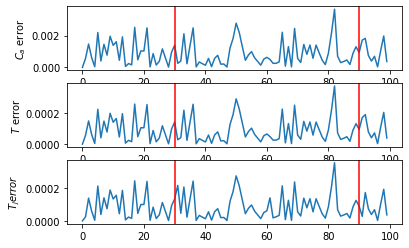

In [11]:
ax1 = plt.subplot(3, 1, 1)
plt.plot(err_ca)
plt.ylabel("$C_{a}$ error")
plt.axvline(x=30, color="r")
plt.axvline(x=90, color="r")


plt.subplot(3, 1, 2, sharex=ax1)
plt.plot(err_t)
plt.ylabel("$T$ error")
plt.axvline(x=30, color="r")
plt.axvline(x=90, color="r")


plt.subplot(3, 1, 3, sharex=ax1)
plt.plot(err_tj)
plt.ylabel("$T_{j} error$")
plt.axvline(x=30, color="r")
plt.axvline(x=90, color="r")
plt.show()

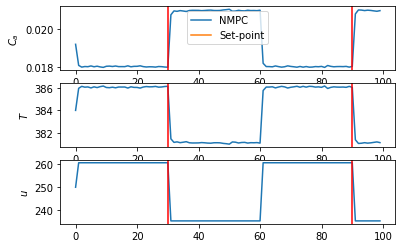

In [12]:
ax1 = plt.subplot(3, 1, 1)
plt.plot(cal)
plt.plot(spl)
plt.ylabel("$C_{a}$")
plt.axvline(x=30, color="r")
plt.axvline(x=90, color="r")
plt.legend(["NMPC", "Set-point"])

plt.subplot(3, 1, 2, sharex=ax1)
plt.plot(tl)
plt.axvline(x=30, color="r")
plt.axvline(x=90, color="r")
plt.ylabel("$T$")


plt.subplot(3, 1, 3, sharex=ax1)
plt.plot(ul)
plt.ylabel("$u$")
plt.axvline(x=30, color="r")
plt.axvline(x=90, color="r")
#plt.title("Control input")
plt.show()

### Credits:
 - David Thierry (Carnegie Mellon University @2019)